In [19]:
import os
import pandas as pd
import json
from sklearn.preprocessing import StandardScaler
import sentence_transformers
from numpy.linalg import norm
import numpy as np
import umap
import pickle
import matplotlib.pyplot as plt
reducer = umap.UMAP()

#### Prepares the data from a ids file and a language


In [2]:
def prepare_datasets(language='latvian'):
    ids_path = "../articles/"+language+"_ids"
    if language == 'estonian':
        lang = 'ee'
    else:
        lang = 'lv'
    ids_list = []
    with open(ids_path, "r") as f:
        for id_ in f:
            ids_list.append(int(id_))
    id2article = {}
    
    for years in ["2018.json", "2019.json"]:
        path = "../articles/" + lang + "_" + years
        articles = json.load(open(path, 'r', encoding='utf-8'))
        for art in articles:
            if int(art['id']) in ids_list:
                id2article[art['id']] = art['title'].lower() + art['bodyText'].lower()
    return id2article

In [3]:
def embedd_texts(text):
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
    embedded = model.encode(text)
    return embedded    

In [27]:
def project_data(data):
    scaled_data = StandardScaler().fit_transform(data)
    l1_norm = np.abs(scaled_data).sum(axis=1)
    scaled_data = scaled_data / l1_norm[:, np.newaxis]
    embedding = reducer.fit_transform(scaled_data)
    return embedding

In [65]:
latvian_articles = prepare_datasets('latvian')

In [66]:
embedded_lv = embedd_texts(list(latvian_articles.values()))

In [67]:
with open('latvan_embeddings.pkl', "wb") as f:
    pickle.dump(embedded_lv, f)

Load proxy articles for Estonian "Lati delfi" documents

In [68]:
delfi_to_ee = pickle.load(open("../estonian_to_latvian_sbert_rankings.pkl","rb"))
#Extract unique ids
unique_ids = set([x for c in delfi_to_ee for x in delfi_to_ee[c]])

Load 21 article pairs

In [111]:
filez = json.load(open("../articles/21_pairs/articles_21.json", encoding='utf-8'))
tarmos21 = []
for file in filez:
    tarmos21.append(file['lv']['title'] + " "+ file['lv']['body'])
embedd_tarmos = embedd_texts(tarmos21)

In [70]:
original_delfi_data = prepare_datasets("delfi")
delfi_embed = embedd_texts(original_delfi_data)

In [71]:
ids2texts = latvian_articles

In [72]:
embedd_docs = pickle.load(open("latvan_embeddings.pkl","rb"))
ids2embs = dict(zip(ids2texts.keys(), embedd_docs))


In [77]:
def project2(embedd_tarmos, delfi_embed, ids2embs, parameter = 10):
    project_ids = set([x for delf in delfi_to_ee for x in delfi_to_ee[delf][:parameter]])
    ee_outs = [ids2embs[key] for key in project_ids]
    merge_embs = np.vstack((embedd_tarmos, np.vstack((ee_outs, embedded_lv))))
    merge_proj = project_data(merge_embs)
    delf_len = len(embedded_lv) #.shape[0]
    main_len = len(ee_outs)#.shape[0]
    tarmo_len = embedd_tarmos.shape[0]
    tarmo_list = project_data(embedd_tarmos)
    #colors = ["orange"] * tarmo_list.shape[0] + ["red"] * main_len + ['blue'] * delf_len
    plt.xlabel('dimension 1')  
    plt.ylabel('dimension 2')  
    plt.title("Latvian document space - k @ " + str(parameter)) 
    #sizes = [150] * (main_len + tarmo_list.shape[0]) + [5] * delf_len
    #plt.legend(loc=0, prop={'tarmo' : 'orange', 'elaine' : 'orange', 'lv_articles' : 'blue'}) 
    plt.scatter(merge_proj[:tarmo_len, 0], merge_proj[:tarmo_len, 1], s = 8, color = "black", marker = "x", zorder=3, label = "GS query documents")#colors)
    plt.scatter(merge_proj[tarmo_len:(main_len + tarmo_len) , 0], merge_proj[tarmo_len:(main_len + tarmo_len), 1], s = 3, color = "#bdbdbd", zorder=2, label = "interesting seed documents")
    plt.scatter(merge_proj[(main_len + tarmo_len):, 0], merge_proj[(main_len + tarmo_len):, 1], s = 1, color = "#636363", zorder=1, label = "other latvian documents")
    plt.legend(loc='best', fontsize=8)
    plt.savefig("../graphics/outs_"+str(parameter)+".pdf")

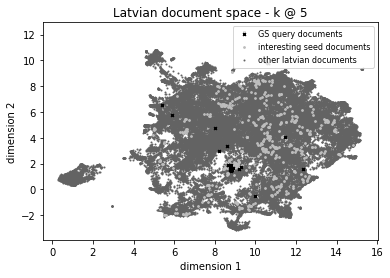

In [78]:
project2(embedd_tarmos, delfi_embed, ids2embs, parameter = 5)

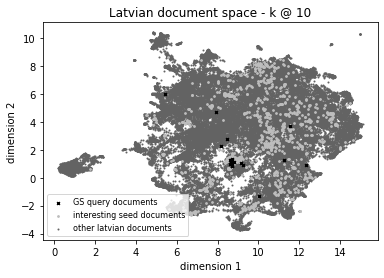

In [79]:
project2(embedd_tarmos, delfi_embed, ids2embs, param eter = 10)

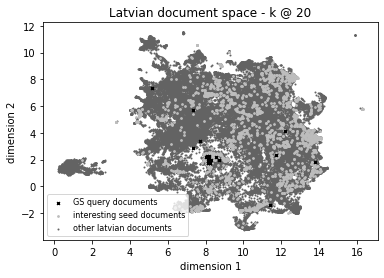

In [110]:
project2(embedd_tarmos, delfi_embed, ids2embs, parameter = 20)

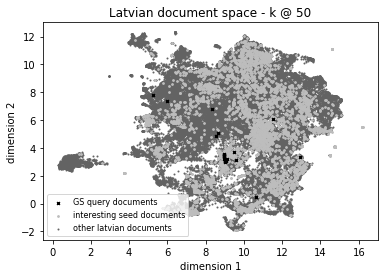

In [81]:
project2(embedd_tarmos, delfi_embed, ids2embs, parameter = 50)

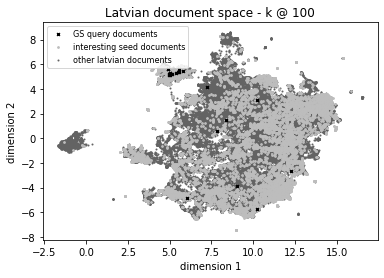

In [82]:
project2(embedd_tarmos, delfi_embed, ids2embs, parameter = 100)

In [87]:
from scipy import spatial
def find_closest_k(tarmos,  delfi_embed, ids2embs, parameter = 5):
    project_ids = set([x for delf in delfi_to_ee for x in delfi_to_ee[delf][:parameter]])
    ee_outs = [ids2embs[key] for key in project_ids]
    tree = spatial.KDTree(ee_outs)
    for tarmo in tarmos:
        #for elaine in ee_outs:
        print(tree.query(tarmo))          

find_closest_k(embedd_tarmos, delfi_embed, ids2embs, parameter = 5)

In [88]:
find_closest_k(embedd_tarmos, delfi_embed, ids2embs, parameter = 10)

(3.2996521833687367, 321)
(4.238930206213552, 201)
(3.7617806859032443, 53)
(3.8526116603113962, 475)
(3.582998802205307, 349)
(3.5658514388779774, 353)
(4.964042149439055, 74)
(3.540288344308021, 122)
(3.6791219324404922, 122)
(4.1127012451446205, 617)
(3.7603726835103055, 679)
(2.7639657796173807, 684)
(3.5251547996562964, 321)
(3.9654913108363474, 878)
(3.8844238889853924, 353)
(3.8210098549451548, 62)
(5.401302481417175, 293)
(3.7758733868902508, 74)
(2.779423730761687, 353)
(3.2771809625436554, 684)
(3.662117452502054, 353)


In [89]:
find_closest_k(embedd_tarmos, delfi_embed, ids2embs, parameter = 50)

(3.2996521833687367, 3410)
(3.981909232721351, 2901)
(3.488909550831859, 3257)
(3.8526116603113962, 1497)
(3.582998802205307, 3449)
(3.387431032997806, 2428)
(4.838375633567699, 84)
(3.5023156863521843, 1588)
(3.6791219324404922, 3190)
(3.7697749024333764, 3564)
(3.7603726835103055, 1718)
(2.7639657796173807, 725)
(3.2716843601325776, 2494)
(3.9654913108363474, 938)
(3.8844238889853924, 2435)
(2.1333642910364383, 237)
(4.50055828832729, 267)
(3.7758733868902508, 3141)
(2.6524739715768852, 706)
(3.2771809625436554, 725)
(3.662117452502054, 2435)


In [90]:
find_closest_k(embedd_tarmos, delfi_embed, ids2embs, parameter = 100)

(3.2996521833687367, 1545)
(3.850731071842787, 4354)
(3.488909550831859, 5146)
(3.8526116603113962, 2533)
(3.582998802205307, 1562)
(3.387431032997806, 2925)
(4.838375633567699, 5565)
(3.4659685326437, 342)
(3.6791219324404922, 6948)
(3.7658081920571895, 1715)
(3.5895166259450457, 902)
(2.7639657796173807, 2185)
(3.2716843601325776, 1140)
(3.9654913108363474, 4109)
(3.521561422954638, 5303)
(2.1333642910364383, 84)
(4.50055828832729, 5654)
(3.773213129460187, 7343)
(2.6524739715768852, 2177)
(3.2771809625436554, 2185)
(3.5206838700513177, 4248)


In [99]:
from scipy import spatial
def find_closest_k_n(tarmos,  delfi_embed, ids2embs, parameter = 5):
    project_ids = set([x for delf in delfi_to_ee for x in delfi_to_ee[delf][:parameter]])
    ee_outs = [ids2embs[key] for key in project_ids]
    len_red_space = len(ee_outs)
    len_blue_space = len(embedded_lv)
    merged = np.vstack((ee_outs, embedded_lv))
    tree = spatial.KDTree(merged)
    k_list = []
    for k in range(3,100):
        ratios = []
        red_hits = 0
        blue_hits = 0
        for tarmo in tarmos:
            #for elaine in ee_outs:
            dist, ind = tree.query(tarmo,k)
            for i in ind:
                if i <= len_red_space:
                    red_hits = red_hits + 1
                else:
                    blue_hits = blue_hits + 1
            blaz_ratio = red_hits / (red_hits+blue_hits)
            ratios.append(blaz_ratio)
        avg_ratio_at_k = sum(ratios)/len(ratios)
        k_list.append(avg_ratio_at_k)
    plt.title('SNIR scores (k=' + parameter + ' and varying size of neighbourhood m)')
    plt.xlabel('m-retrieved neighbours')  
    plt.ylabel('SNIR') 
    plt.plot(list(range(3,100)), k_list)
        

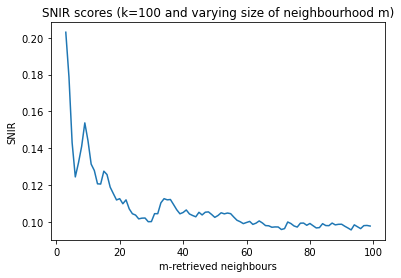

In [97]:
find_closest_k_n(embedd_tarmos, delfi_embed, ids2embs, parameter = 100)

In [125]:
import datetime
date_last_7_f = '2019-11-30T07:00:00.000Z'
date_last_7 = datetime.datetime.strptime(date_last_7_f, '%Y-%m-%dT%H:%M:%S.%fZ')

In [126]:
json_files = ["../articles/lv_2019.json"]
parse_lasts = []
titles_lasts = []
ids_eval = []
with open('../articles/final_eval_ids', "r") as f:
    for l in f.readlines():
        ids_eval.append(int(l))    
for jf in json_files:
    print("JSON file:", jf)
    articles = json.load(open(jf, 'r', encoding='utf-8'))
    print("Articles:", len(articles))
    for art in articles:
        timez = datetime.datetime.strptime(art["publishDate"], '%Y-%m-%dT%H:%M:%S.%fZ')
        if art['id'] in ids_eval and timez >= date_last_7 and art["channelLanguage"] == 'nat':   
            texts = art['title'].lower() + ' ' + art['bodyText'].lower()
            parse_lasts.append(texts)
            titles_lasts.append(art['title'].lower())

JSON file: ../articles/lv_2019.json
Articles: 29070


In [127]:
embedd_last_7 = embedd_texts(parse_lasts)

In [131]:
from scipy import spatial
import random
def find_closest_k_n_2_cols(tarmos,  delfi_embed, ids2embs, parameter = 5):
    project_ids = set([x for delf in delfi_to_ee for x in delfi_to_ee[delf][:parameter]])
    ee_outs = [ids2embs[key] for key in project_ids]
    len_red_space = len(ee_outs)
    len_blue_space = len(embedded_lv)
    merged = np.vstack((ee_outs, embedded_lv))
    tree = spatial.KDTree(merged)
    random_pivots = random.choices(embedded_lv, k = 21)
    plt.title('SNIR scores (k=100 and varying size of neighbourhood m)')
    plt.xlabel('m-retrieved neighbours')  
    plt.ylabel('SNIR') 

    for name, pivot in [("GS query documents",tarmos), ("random documents", random_pivots)]:
        k_list = []
        for k in range(3,100):
            ratios = []
            red_hits = 0
            blue_hits = 0
            for tarmo in pivot:
                #for elaine in ee_outs:
                dist, ind = tree.query(tarmo,k)
                for i in ind:
                    if i <= len_red_space:
                        red_hits = red_hits + 1
                    else:
                        blue_hits = blue_hits + 1
                blaz_ratio = red_hits / (red_hits+blue_hits)
                ratios.append(blaz_ratio)
            avg_ratio_at_k = sum(ratios)/len(ratios)
            k_list.append(avg_ratio_at_k)
        plt.plot(list(range(3,100)), k_list, label = name)
    plt.legend(loc='best')
    plt.savefig('../graphics/qr_eval.pdf')

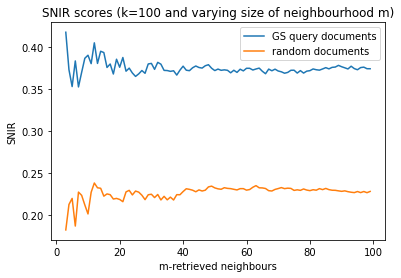

In [132]:
find_closest_k_n_2_cols(embedd_tarmos, delfi_embed, ids2embs, parameter = 100)

In [128]:
from scipy import spatial
def analyze_possible(tarmos,  delfi_embed, ids2embs, titles, parameter = 5, k = 20):
    project_ids = set([x for delf in delfi_to_ee for x in delfi_to_ee[delf][:parameter]])
    ee_outs = [ids2embs[key] for key in project_ids]
    len_red_space = len(ee_outs)
    len_blue_space = len(embedded_lv) 
    merged = np.vstack((ee_outs, embedded_lv))
    tree = spatial.KDTree(merged)
    k_list = []
    ratios = []
    red_hits = 0
    blue_hits = 0
    for title, text, ids, tarmo in zip(titles,parse_lasts,ids_lasts, tarmos):
        #for elaine in ee_outs:
        dist, ind = tree.query(tarmo,k)
        for i in ind:
            if i <= len_red_space:
                red_hits = red_hits + 1
            else:
                blue_hits = blue_hits + 1
        blaz_ratio = red_hits / (red_hits+blue_hits)
        
        ratios.append((title, text, ids, blaz_ratio))
    return ratios

In [129]:
out_df = analyze_possible(embedd_last_7, delfi_embed, ids2embs, titles_lasts, parameter = 20, k = 100)

In [130]:
import pandas as pd
x = pd.DataFrame(out_df)
x["id"] = x[2]
x["text"] = x[1]
x["score"] = x[3]
del x[0]
del x[1]
del x[2]
del x[3]
x = x.sort_values(by=['score'], ascending=False)
x["score"].describe()
x


,id,text,score
1,51671721,elektrisko skrejriteņu bums: izbeidz latvijā p...,0.075000
25,51682113,sveču gaismā pie brīvības pieminekļa piemin ru...,0.062692
299,51695961,"bēgļu nometne lesbas salā apdraud sievietes, u...",0.060667
300,51696295,baltkrievija negrasās kļūt par daļu no brālīgā...,0.060532
292,51695673,foto: svinīgi atzīmē valsts policijas 101. gad...,0.060512
...,...,...,...
37,51598139,par bērnu pornogrāfijas apriti piespriež nosac...,0.048158
5,51678669,"aleksandra kostjukoviča, ingus rūtiņš: moderni...",0.043333
3,51675645,no 1. decembra transportlīdzekļiem obligāti jā...,0.040000
4,51676189,"vecākiem, kuru bērns saindējās ar metadonu, bū...",0.034000
